In [1]:
# https://www.worldometers.info/coronavirus/country/us/

import os
os.getcwd()
os.chdir('/Users/lisun/ARIMA/USA')

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.offline as off
off.init_notebook_mode(connected=True)

from datetime import date
from datetime import datetime

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot


import warnings
warnings.filterwarnings("ignore")


In [3]:
confirmed_Global=pd.read_csv('confirmed_Global.csv')
confirmed_USA=pd.read_csv('confirmed_USA_state.csv')
confirmed_Global.drop('Unnamed: 0', axis=1, inplace=True)
confirmed_USA.drop('Unnamed: 0', axis=1, inplace=True)

In [6]:
df_UnitedStates = confirmed_Global[confirmed_Global['Country/Region']=='United States']
df_Italy = confirmed_Global[confirmed_Global['Country/Region']=='Italy']
df_USA_NY = confirmed_USA[confirmed_USA['Province/State']=='New York']
df_USA_CA = confirmed_USA[confirmed_USA['Province/State']=='California']
df_USA_NJ = confirmed_USA[confirmed_USA['Province/State']=='New Jersey']
df_USA_GA = confirmed_USA[confirmed_USA['Province/State']=='Georgia']

In [4]:
def stackDF(df):
    namelist = ['Province/State','Country/Region','Lat','Long',' Population ','region']
    new_df=df.drop(namelist, axis=1).reset_index(drop=True).stack().reset_index()
    new_df.drop('level_0', axis=1, inplace=True)
    new_df['level_1']=new_df['level_1'].apply(lambda x: datetime.strptime(x,'%m/%d/%y').date())
    new_df.set_index('level_1', inplace=True)
    new_df.rename(columns={new_df.columns[0]: 'confirmed'}, inplace=True)
    new_df.index.names=['Date']
    
    return new_df

In [7]:
UnitedStates=stackDF(df_UnitedStates)
Italy=stackDF(df_Italy)
USA_NY=stackDF(df_USA_NY)
USA_CA=stackDF(df_USA_CA)
USA_NJ=stackDF(df_USA_NJ)
USA_GA=stackDF(df_USA_GA)

In [8]:
df=UnitedStates.copy()
# df=USA_GA.copy()
# df=USA_NY.copy()
# df = Italy.copy()

In [11]:
from datetime import date
def get_imageName(prefix):
    return prefix +'_'+str(date.today())

In [15]:
data = [go.Bar(x=df.index,y=df['confirmed'])]
layout = go.Layout(
    title= "The Confirmed COVID-19 Cases in USA",
    yaxis=dict(
        title= dict(text = 'Confirmed Cases', font = dict(color = 'black'))      
    ),
    xaxis=dict(
        title= dict(text = 'Date',font = dict(color = 'black')),
        tickangle = -45,
        tickfont=dict(size = 8),
        automargin=True
    )
)

fig = go.Figure(data=data, layout=layout)
fig.write_html('Plots/'+ get_imageName('USA')+'.html')    # save as html file
fig.write_image('Plots/'+ get_imageName('USA')+'.pdf')    # save as image file
off.iplot(fig)

## Determine if the Data is Stationary

There are two primary way to determine whether a given time series is stationary

1. Rolling Statistics
2. Augmented Dickey-Fuller Test

In [11]:
def get_stationarity(timeseries, N, name):
    # rolling statistics
    rolling_mean = timeseries.rolling(window=N).mean()
    rolling_std = timeseries.rolling(window=N).std()
    
    # rolling statistics plot
    plt.figure(figsize=(12, 3))
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & SD - '+name)
#     plt.savefig('Rolling Statistics/'+name+'.pdf')
    plt.show(block=False)
    
    
    # Dickey-Fuller test:
    result = adfuller(timeseries['confirmed'])
    
    f = open('Rolling Statistics/'+name +'1.txt', 'w')
    print(result, file = f)
#     f.write(result)      #T ypeError: write() argument must be str, not tuple
    f.close()
    
    print(" > Is the data stationary ?")
    print('ADF Statistics = {:.4f}'.format(result[0]))
    print('p-value = {:.4f}'.format(result[1]))
    print('Critical Values:')
    for k, v in result[4].items():  
        print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "NOT" if v<result[0] else "", 100-int(k[:-1])))

### Rolling Statistics

1. Original Series
2. Subtract Rolling Mean
3. De-trending 
4. Differencing 

#### 1. Original Series

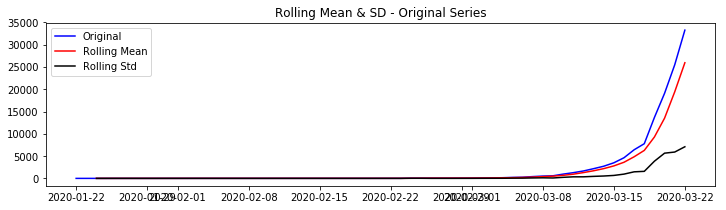

 > Is the data stationary ?
ADF Statistics = 3.4268
p-value = 1.0000
Critical Values:
	1%: -3.5714715250448363 - The data is NOT stationary with 99% confidence
	5%: -2.922629480573571 - The data is NOT stationary with 95% confidence
	10%: -2.5993358475635153 - The data is NOT stationary with 90% confidence


In [13]:
N = 3

get_stationarity(df,N, 'Original Series')

#### 2. Subtract Rolling Mean

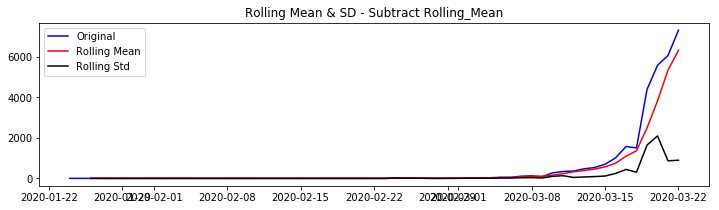

 > Is the data stationary ?
ADF Statistics = 3.6937
p-value = 1.0000
Critical Values:
	1%: -3.5778480370438146 - The data is NOT stationary with 99% confidence
	5%: -2.925338105429433 - The data is NOT stationary with 95% confidence
	10%: -2.6007735310095064 - The data is NOT stationary with 90% confidence


In [11]:
rolling_mean = df.rolling(window=N).mean()
rolling_std = df.rolling(window=N).std()

df_minus_mean=df-rolling_mean
df_minus_mean.dropna(inplace=True)

get_stationarity(df_minus_mean,N, 'Subtract Rolling_Mean')

#### 3. De-Trending

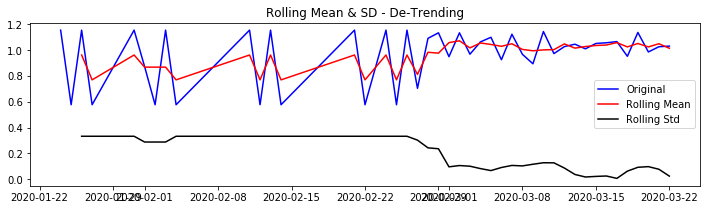

 > Is the data stationary ?
ADF Statistics = -1.3933
p-value = 0.5855
Critical Values:
	1%: -3.6055648906249997 - The data is NOT stationary with 99% confidence
	5%: -2.937069375 - The data is NOT stationary with 95% confidence
	10%: -2.606985625 - The data is NOT stationary with 90% confidence


In [12]:
df_DeTrending=(df-rolling_mean)/rolling_std
df_DeTrending.dropna(inplace=True)

get_stationarity(df_DeTrending,N, 'De-Trending')

#### 4. Differencing

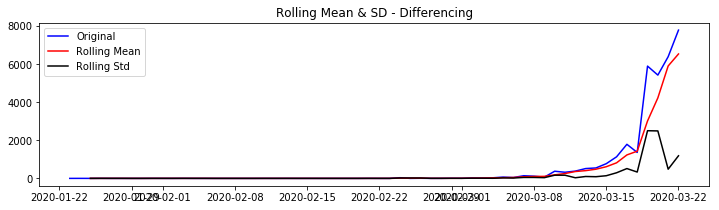

 > Is the data stationary ?
ADF Statistics = 25.7910
p-value = 1.0000
Critical Values:
	1%: -3.5656240522121956 - The data is NOT stationary with 99% confidence
	5%: -2.920142229157715 - The data is NOT stationary with 95% confidence
	10%: -2.598014675124952 - The data is NOT stationary with 90% confidence


In [13]:
df_differencing=df-df.shift(1)      # same as df.diff(1)

df_differencing.dropna(inplace=True)

get_stationarity(df_differencing,N, 'Differencing')

The rolling mean and rolling std increase with time. So the time series is NOT stationary

All ADF Statistics are far from critical values (if the ADF test is positive, automatically decided NOT to reject the NULL hypothesis), and the p-values are greater than the threshold(0.05)

Conclusion: the time series are NOT stationary

## Apply transformation to render it stationary
### Log the data to lower increasing

Taking the log of the dependent variable is simple way of lowering the rate at which rolling mean increase
1. Log
2. Subtract Rolling Mean
3. Exponential decay
4. Differencing

#### 1. Log

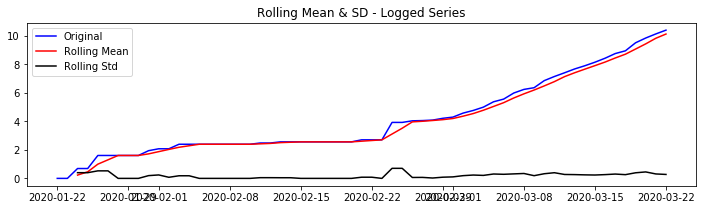

 > Is the data stationary ?
ADF Statistics = 2.0852
p-value = 0.9988
Critical Values:
	1%: -3.5443688564814813 - The data is NOT stationary with 99% confidence
	5%: -2.9110731481481484 - The data is NOT stationary with 95% confidence
	10%: -2.5931902777777776 - The data is NOT stationary with 90% confidence


In [14]:
df_log = np.log(df)

get_stationarity(df_log,N, 'Logged Series')

#### 2. Subtract Rolling Mean

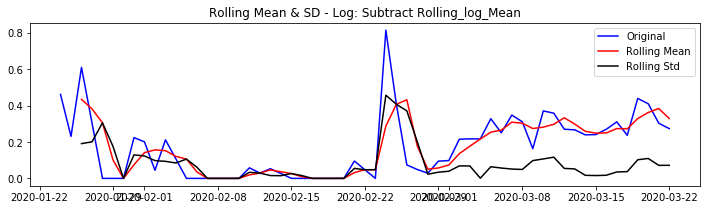

 > Is the data stationary ?
ADF Statistics = -4.3615
p-value = 0.0003
Critical Values:
	1%: -3.548493559596539 - The data is  stationary with 99% confidence
	5%: -2.912836594776334 - The data is  stationary with 95% confidence
	10%: -2.594129155766944 - The data is  stationary with 90% confidence


In [15]:
rolling_log_mean = df_log.rolling(window=N).mean()
rolling_log_std = df_log.rolling(window=N).std() # have value 0

df_log_minus_mean=df_log-rolling_log_mean
df_log_minus_mean.dropna(inplace=True)

get_stationarity(df_log_minus_mean,N, 'Log: Subtract Rolling_log_Mean')

###### After subtraction the mean, the rolling mean and standard deviation are approximately parallel and horizontal ( the vertical unit of coordination is small). The p-value is below the threshold of 0.01, and the ADF statistics is close to the critical values. Therefore, the time series is stationary. 

#### 3. Exponential decay

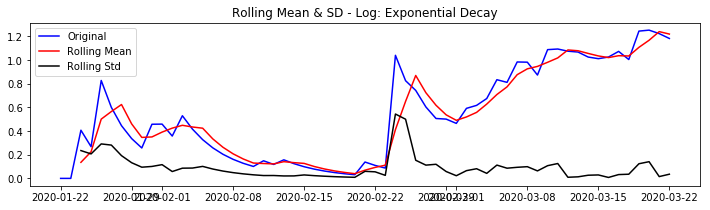

 > Is the data stationary ?
ADF Statistics = -1.6643
p-value = 0.4496
Critical Values:
	1%: -3.5443688564814813 - The data is NOT stationary with 99% confidence
	5%: -2.9110731481481484 - The data is NOT stationary with 95% confidence
	10%: -2.5931902777777776 - The data is NOT stationary with 90% confidence


In [16]:
rolling_mean_exp_decay = df_log.ewm(halflife=N, min_periods=0, adjust=True).mean()
df_log_exp_decay = df_log - rolling_mean_exp_decay
df_log_exp_decay.dropna(inplace=True)

get_stationarity(df_log_exp_decay,N,'Log: Exponential Decay')

#### 4. Differencing

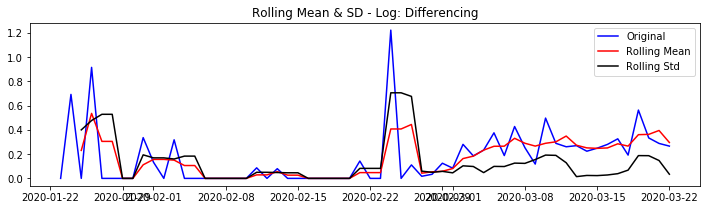

 > Is the data stationary ?
ADF Statistics = -3.0216
p-value = 0.0329
Critical Values:
	1%: -3.5506699942762414 - The data is NOT stationary with 99% confidence
	5%: -2.913766394626147 - The data is  stationary with 95% confidence
	10%: -2.5946240473991997 - The data is  stationary with 90% confidence


In [17]:
df_log_shift = df_log-df_log.shift(1) # same as df_log.diff(1)
df_log_shift.dropna(inplace = True)

get_stationarity(df_log_shift,N,'Log: Differencing')

##### The shifting performed worse than subtracting the rolling mean. However it is still more stationary than the original.

## ARIMA (aka Box-Jenkins)

Three integers (p, d, q) are typically used to parametrize ARIMA models.

p: number of autoregressive terms (AR order)

d: number of nonseasonal differences (differencing order)

q: number of moving-average terms (MA order)

### ACF and PACF 
An autocorrelation (ACF) plot represents the autocorrelation of the series with lags of itself. 

A partial autocorrelation (PACF) plot represents the amount of correlation between a series and a lag of itself that is not explained by correlations at all lower-order lags.

Ideally, we want no correlation between the series and lags of itself. 

Graphically speaking, we would like all the spikes to fall in the blue region

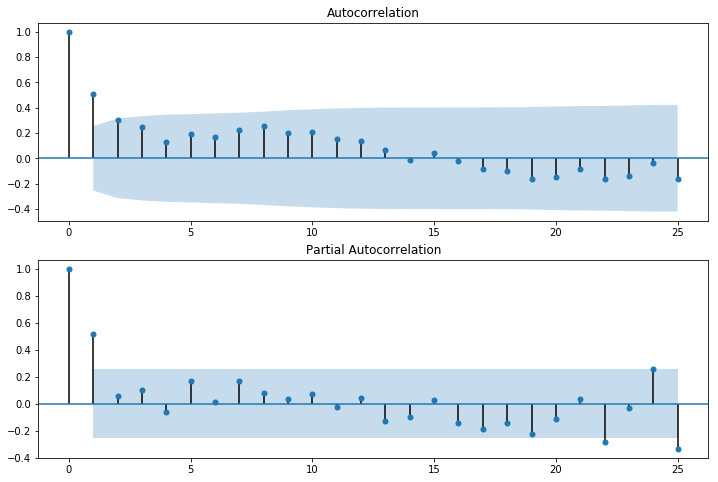

In [17]:
fig = plt.figure(figsize = (12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_log_minus_mean.values.squeeze(),
                              lags = 25, ax = ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_log_minus_mean.values.squeeze(),
                               lags = 25, ax = ax2)
plt.savefig('ARIMA/ACFandPACF_USA.pdf')
plt.show()

### 1. Choosing the differencing order
— Rule 1 : If the series has positive autocorrelations out to a high number of lags, then it probably needs a higher order of differencing. 

— Rule 2 : If the lag-1 autocorrelation is zero or negative, or the autocorrelations are all small and patternless, then the series does not need a higher order of differencing. If the lag-1 autocorrelation is -0.5 or more negative, the series may be overdifferenced.

(Robert Nau, Statistical Forecasting)

                              ARMA Model Results                              
Dep. Variable:              confirmed   No. Observations:                   59
Model:                     ARMA(0, 0)   Log Likelihood                  19.339
Method:                           css   S.D. of innovations              0.174
Date:                Thu, 16 Apr 2020   AIC                            -34.677
Time:                        20:56:40   BIC                            -30.522
Sample:                    01-24-2020   HQIC                           -33.055
                         - 03-22-2020                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1750      0.023      7.709      0.000       0.130       0.219
                             ARIMA Model Results                              
Dep. Variable:            D.confirmed   No. Observat

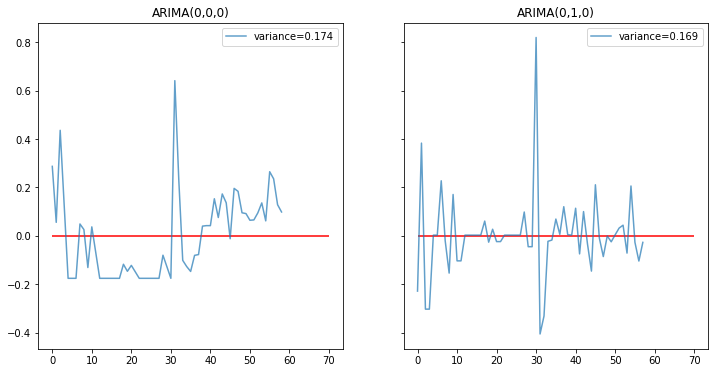

In [16]:
model = ARIMA(df_log_minus_mean.dropna(), (0, 0, 0))
res_000 = model.fit()
print(res_000.summary())

model = ARIMA(df_log_minus_mean.dropna(), (0, 1, 0))
res_010 = model.fit()
print(res_010.summary())


fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
ax[0].plot(res_000.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_000.resid.values)));
ax[0].hlines(0, xmin=0, xmax=70, color='r');
ax[0].set_title("ARIMA(0,0,0)");
ax[0].legend();
ax[1].plot(res_010.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_010.resid.values)));
ax[1].hlines(0, xmin=0, xmax=70, color='r');
ax[1].set_title("ARIMA(0,1,0)");
ax[1].legend();


print('ARIMA(0,0,0): AIC = '+ str(res_000.aic))
print('ARIMA(0,1,0): AIC = '+ str(res_010.aic))

#### Check results by comparing a (0,0,0) and a( 0, 1, 0) ARIMA model

ARIMA(0,1,0) has lowered both the AIC and variance, meaning this model is performing better than the ARIMA(0,0,0)

### 2. Choosing the MA order
If the lag-1 autocorrelation of the differenced series ACF is negative, and/or there is a sharp cutoff, then choose a MA order of 1

usually not recommended to go beyond 2

### 3. Choosing the AR order
If the lag-1 autocorrelation of the differenced series PACF is negative, and/or there is a sharp cutoff, then choose a AR order of 1.

### 4. Choosing the best parameters 

                              ARMA Model Results                              
Dep. Variable:              confirmed   No. Observations:                   59
Model:                     ARMA(0, 1)   Log Likelihood                  27.406
Method:                       css-mle   S.D. of innovations              0.152
Date:                Mon, 30 Mar 2020   AIC                            -48.812
Time:                        01:18:43   BIC                            -42.579
Sample:                    01-24-2020   HQIC                           -46.379
                         - 03-22-2020                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1787      0.030      5.882      0.000       0.119       0.238
ma.L1.confirmed     0.5480      0.132      4.147      0.000       0.289       0.807
                                

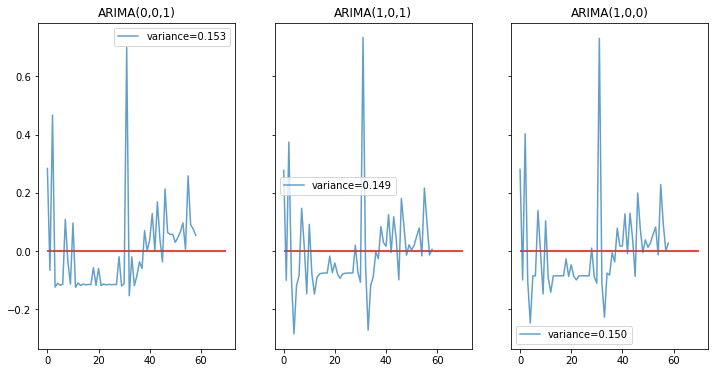

In [20]:
model = ARIMA(df_log_minus_mean.dropna(), (0, 0, 1))
res_001 = model.fit()
print(res_001.summary())

model = ARIMA(df_log_minus_mean.dropna(), (1, 0, 1))
res_101 = model.fit()
print(res_101.summary())

model = ARIMA(df_log_minus_mean.dropna(), (1, 0, 0))
res_100 = model.fit()
print(res_100.summary())



fig, ax = plt.subplots(1, 3, sharey=True, figsize=(12, 6))
ax[0].plot(res_001.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_001.resid.values)));
ax[0].hlines(0, xmin=0, xmax=70, color='r');
ax[0].set_title("ARIMA(0,0,1)");
ax[0].legend();
ax[1].plot(res_101.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_101.resid.values)));
ax[1].hlines(0, xmin=0, xmax=70, color='r');
ax[1].set_title("ARIMA(1,0,1)");
ax[1].legend();
ax[2].plot(res_100.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_100.resid.values)));
ax[2].hlines(0, xmin=0, xmax=70, color='r');
ax[2].set_title("ARIMA(1,0,0)");
ax[2].legend();

                             ARIMA Model Results                              
Dep. Variable:            D.confirmed   No. Observations:                   58
Model:                 ARIMA(0, 1, 1)   Log Likelihood                  26.051
Method:                       css-mle   S.D. of innovations              0.154
Date:                Mon, 30 Mar 2020   AIC                            -46.102
Time:                        01:18:46   BIC                            -39.921
Sample:                    01-25-2020   HQIC                           -43.694
                         - 03-22-2020                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0006      0.008     -0.075      0.940      -0.016       0.014
ma.L1.D.confirmed    -0.6383      0.157     -4.054      0.000      -0.947      -0.330
                        

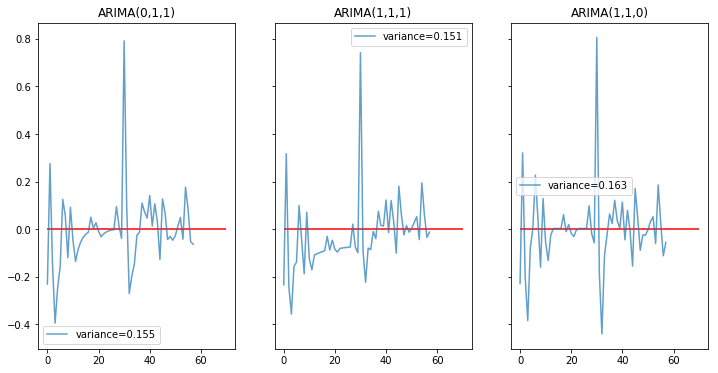

In [21]:
model = ARIMA(df_log_minus_mean.dropna(), (0, 1, 1))
res_011 = model.fit()
print(res_011.summary())

model = ARIMA(df_log_minus_mean.dropna(), (1, 1, 1))
res_111 = model.fit()
print(res_111.summary())

model = ARIMA(df_log_minus_mean.dropna(), (1, 1, 0))
res_110 = model.fit()
print(res_110.summary())



fig, ax = plt.subplots(1, 3, sharey=True, figsize=(12, 6))
ax[0].plot(res_011.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_011.resid.values)));
ax[0].hlines(0, xmin=0, xmax=70, color='r');
ax[0].set_title("ARIMA(0,1,1)");
ax[0].legend();
ax[1].plot(res_111.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_111.resid.values)));
ax[1].hlines(0, xmin=0, xmax=70, color='r');
ax[1].set_title("ARIMA(1,1,1)");
ax[1].legend();
ax[2].plot(res_110.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_110.resid.values)));
ax[2].hlines(0, xmin=0, xmax=70, color='r');
ax[2].set_title("ARIMA(1,1,0)");

##### Last round of comparison

ARIMA(1,1,1): AIC = -46.51095259980883
ARIMA(1,0,1): AIC = -49.802168487064705
ARIMA(1,0,0): AIC = -51.451117275762215


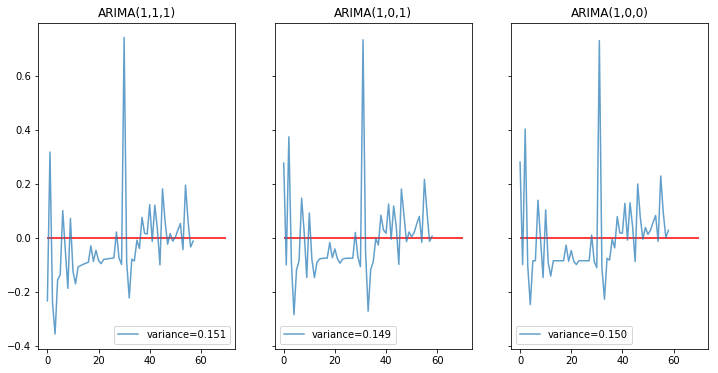

In [38]:
model = ARIMA(df_log_minus_mean.dropna(), (1, 1, 1))
res_111 = model.fit()
# print(res_111.summary()[1])
print('ARIMA(1,1,1): AIC = '+ str(res_111.aic))

model = ARIMA(df_log_minus_mean.dropna(), (1, 0, 1))
res_101 = model.fit()
# print(res_101.summary())
print('ARIMA(1,0,1): AIC = '+ str(res_101.aic))

model = ARIMA(df_log_minus_mean.dropna(), (1, 0, 0))
res_100 = model.fit()
# print(res_100.summary())
print('ARIMA(1,0,0): AIC = '+ str(res_100.aic))



fig, ax = plt.subplots(1, 3, sharey=True, figsize=(12, 6))
ax[0].plot(res_111.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_111.resid.values)));
ax[0].hlines(0, xmin=0, xmax=70, color='r');
ax[0].set_title("ARIMA(1,1,1)");
ax[0].legend();
ax[1].plot(res_101.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_101.resid.values)));
ax[1].hlines(0, xmin=0, xmax=70, color='r');
ax[1].set_title("ARIMA(1,0,1)");
ax[1].legend();
ax[2].plot(res_100.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_100.resid.values)));
ax[2].hlines(0, xmin=0, xmax=70, color='r');
ax[2].set_title("ARIMA(1,0,0)");
ax[2].legend();

##### The ARIMA(1,0,0) has the lowest AIC and second lowest variance.

### Conclusion: choose ARIMA(1,0,0) on log_minus_mean as final model

In [39]:
model = ARIMA(df_log_minus_mean.dropna(), order = (1,0,0))
results_mean = model.fit(disp = -1)

#### Plot Fitted Values

In [40]:
# have same index
RMSE = np.sqrt(sum((df_log_minus_mean.ix[results_mean.fittedvalues.index,0]-results_mean.fittedvalues)**2)/results_mean.fittedvalues.size)
print('RMSE: %.4f'% RMSE)

# convert Series file to Data Frame
a =results_mean.fittedvalues.to_frame()
a.rename(columns={0:'confirmed'}, inplace=True)

trace1 = go.Scatter(y = a['confirmed'],x = a.index,mode = 'lines',name = 'MRIMA')
trace0 = go.Scatter(y = df_log_minus_mean['confirmed'],x = df_log_minus_mean.index,mode = 'lines',name = 'df_log_minus_mean')
data = [trace0, trace1]
layout = dict(
    title = 'ARIMA(1,0,0) Fitted Values _ USA' +'<br>'+'RMSE: %.4f'% RMSE, 
    xaxis=dict(
        title= dict(text = 'Date',font = dict(color = 'black')),
        tickangle = -45,
        tickfont=dict(size = 4),
        automargin=True)
)
fig = go.Figure(data, layout)
off.iplot(fig)
fig.write_html('Plots/ARIMA_fittedValues.html')    # save as html file
fig.write_image('Plots/ARIMA_fittedValues.pdf')    # save as image file

RMSE: 0.1495


In [24]:
# model = ARIMA(df_log_minus_mean.dropna(), order = (1,1,1))
# results_mean = model.fit(disp = -1)
# RMSE = np.sqrt(sum((df_log_minus_mean.ix[results_mean.fittedvalues.index,0]-results_mean.fittedvalues)**2)/results_mean.fittedvalues.size)
# print('RMSE: %.4f'% RMSE)

# # convert Series file to Data Frame
# a =results_mean.fittedvalues.to_frame()
# a.rename(columns={0:'confirmed'}, inplace=True)

# trace1 = go.Scatter(y = a['confirmed'],x = a.index,mode = 'lines',name = 'MRIMA')
# trace0 = go.Scatter(y = df_log_minus_mean['confirmed'],x = df_log_minus_mean.index,mode = 'lines',name = 'df_log_minus_mean')
# data = [trace0, trace1]
# layout = dict(
#     title = 'ARIMA(1,1,1) Fitted Values _ USA' +'<br>'+'RMSE: %.4f'% RMSE, 
#     xaxis=dict(
#         title= dict(text = 'Date',font = dict(color = 'black')),
#         tickangle = -45,
#         tickfont=dict(size = 4),
#         automargin=True)
# )
# fig = go.Figure(data, layout)
# off.iplot(fig)

RMSE: 0.2633


### Compare model with original time series

In [41]:
predictions_ARIMA_diff = pd.Series(results_mean.fittedvalues, copy = True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
# Predictions_ARIMA_log = pd.Series(df_log['confirmed'].iloc[0], index = df_log.index)
Predictions_ARIMA_log = pd.Series(df_log['confirmed'].iloc[0], index = predictions_ARIMA_diff_cumsum.index)
Predictions_ARIMA_log = Predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value = 0)
Predictions_ARIMA = np.exp(Predictions_ARIMA_log)

RMSE = np.sqrt(sum((df.ix[predictions_ARIMA_diff_cumsum.index,0]-Predictions_ARIMA)**2)/Predictions_ARIMA.size)
print('RMSE: %.4f'% RMSE)

# convert Series file to Data Frame
df_pred =Predictions_ARIMA.to_frame()
df_pred.rename(columns={0:'predicted'}, inplace=True)

trace0 = go.Scatter(y = df['confirmed'],x = df.index, mode = 'lines, markers',name = 'Confirmed Cases')
trace1 = go.Scatter(y = df_pred['predicted'],x = df_pred.index,mode = 'lines, markers',name = 'Predicted Cases')

data = [trace0, trace1]
layout = dict(
    title = 'Comparison Between Confirmed and Predicted Cases of USA'+'<br>'+'RMSE: %.4f'% RMSE, 
    xaxis=dict(
        title= dict(text = 'Date',font = dict(color = 'black')),
        tickangle = -45,
        tickfont=dict(size = 4),
        automargin=True)
)

fig = go.Figure(data, layout)
off.iplot(fig)
fig.write_html('Plots/ComparisonOriginalandPredicted.html')    # save as html file
fig.write_image('Plots/ComparisonOriginalandPredicted.pdf')    # save as image file

RMSE: 1049.0673


##### Combine the predicted data into the original table

In [21]:
## convert columns to row
bb =df_pred.rename_axis(None).astype(int).T
## Append to the original table
namelist = ['Province/State','Country/Region','Lat','Long',' Population ','region']
predTable=df_UnitedStates.drop(namelist, axis=1).reset_index(drop=True)
predTable.rename(index={0:'confirmed'},inplace=True)
predTable.ix['predicte',2:]=bb.iloc[0].values

predTable.to_csv('Files/Internal Prediction Table_USA.csv')

## Check Residual

https://otexts.com/fpp2/residuals.html
1. The residuals are uncorrelated. If there are correlations between residuals, then there is information left in the residuals which should be used in computing forecasts.
2. The residuals have zero mean. If the residuals have a mean other than zero, then the forecasts are biased.

3. The residuals have constant variance.
4. The residuals are normally distributed.

### 1. check if residuals are uncorrelated

##### The lack of correlation suggesting the forecasts are good
If no significant correlations are present, you can conclude that the residuals are independent. However, you may see 1 or 2 significant correlations at higher order lags that are not seasonal lags. These correlations are usually caused by random error instead and are not a sign that the assumption is not met. In this case, you can conclude that the residuals are independent.


###### a.  Plots visualization

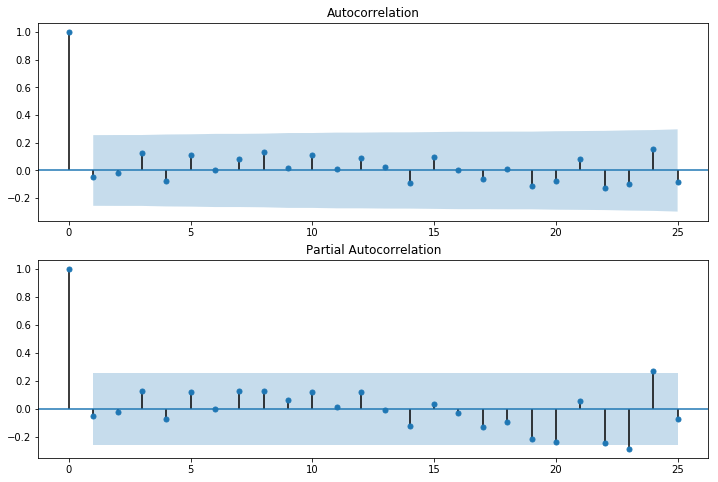

In [26]:
fig = plt.figure(figsize = (12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(results_mean.resid.values.squeeze(),
                              lags = 25, ax = ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(results_mean.resid.values.squeeze(),
                               lags = 25, ax = ax2)
plt.savefig('ARIMA/ACF and PACF _residual_USA.pdf')
plt.show()

###### b. Using Durbin-Watson 

Using Durbin-Watson (only for first order diffferencing  ??)

0<= DW<= 4 DW = 0 => p = 1 positive autocorrelation

DW = 4 => p =-1 negative autocorrelation

DW = 2 => p = 0 no autocorrelation

Durbin Watson Statistic Definition By WILL KENTON Updated Jul 18, 2019 What Is the Durbin Watson Statistic? The Durbin Watson (DW) statistic is a test for autocorrelation in the residuals from a statistical regression analysis. The Durbin-Watson statistic will always have a value between 0 and 4. A value of 2.0 means that there is no autocorrelation detected in the sample. Values from 0 to less than 2 indicate positive autocorrelation and values from from 2 to 4 indicate negative autocorrelation.

In [27]:
print(sm.stats.durbin_watson(results_mean.resid.values))

2.0331424584092126


### 2. Check if residuals are normal distributed

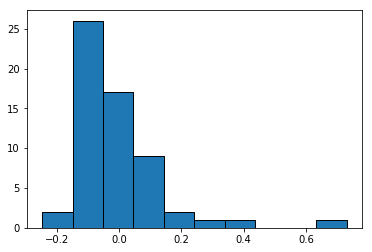

In [28]:
plt.hist(results_mean.resid.values.squeeze(), bins=10, edgecolor = 'black') 
plt.show()

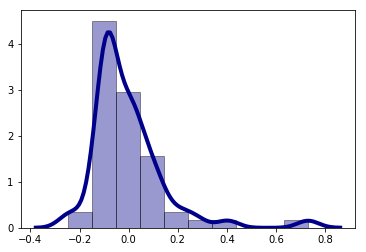

In [29]:
import seaborn as sns
# Density Plot and Histogram of all arrival delays
sns.distplot(results_mean.resid.values.squeeze(), hist=True, kde=True, 
             bins=10, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
plt.savefig('ARIMA/Histogram_residual_USA.pdf')
plt.show()

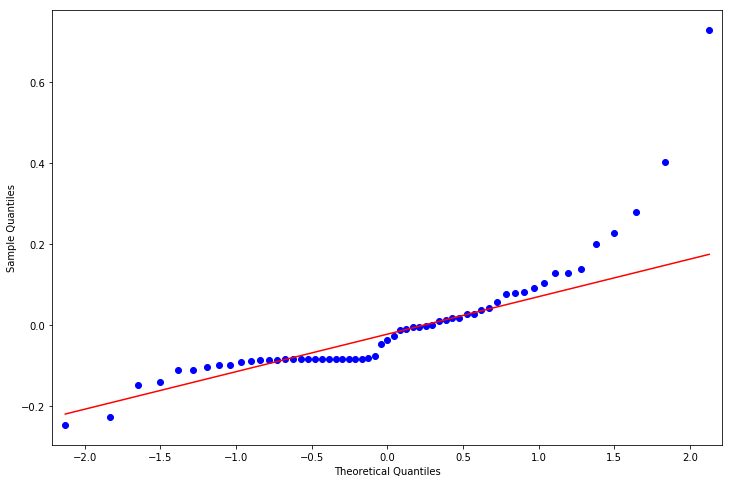

In [30]:
fig = plt.figure(figsize= (12,8))
ax1 = fig.add_subplot(111)
fig = qqplot(results_mean.resid, ax = ax1, line='q')
plt.savefig('ARIMA/ggplot_residual_USA.pdf')
plt.show()

### 4. Check if residuals have zero mean

mean of the residuals: -0.0025


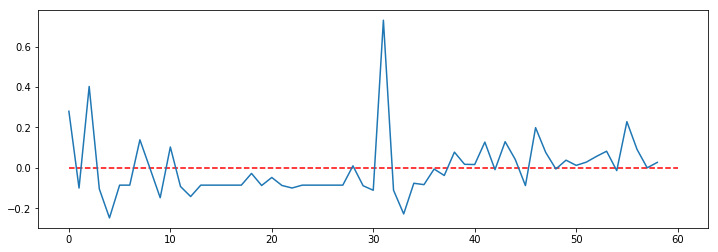

In [61]:
fig, ax = plt.subplots(figsize= (12,4))
plt.plot(results_mean.resid.values.squeeze())
ax.hlines(0, 0, 60, linestyle='--', color='r');
plt.savefig('ARIMA/Residual Mean_USA.pdf')
print('mean of the residuals: {:0.4f}'.format(results_mean.resid.values.mean()))
plt.show()

## Predictions
Highly recommend to put data in a DataFrame with a DateTimeIndex, because the plot_predict() method really likes dates

### Prediction of internal sample data

Start Date of forecast:  2020-03-10


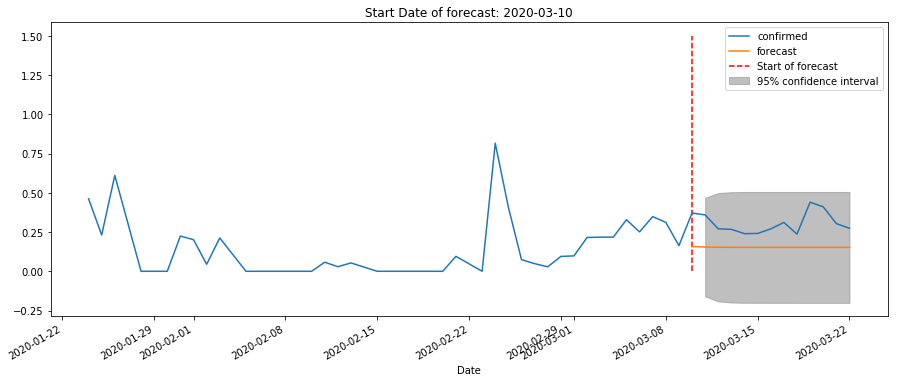

In [19]:
n = 12

model_test = ARIMA(df_log_minus_mean.dropna()[:-n], (1, 0, 0))
results_mean_test = model_test.fit()

startDate = df_log_minus_mean.dropna()[:-n].index[-1]
print('Start Date of forecast: ', startDate)

fig, ax = plt.subplots(figsize=(15, 6))
df_log_minus_mean.dropna().plot(ax=ax);
ax.vlines(startDate, 0, 1.5, linestyle='--', color='r', label='Start of forecast');
plt.title('Start Date of forecast: '+str(startDate))
ax = results_mean_test.plot_predict(start=startDate,end='2020, 3, 22', dynamic=True,plot_insample=False,ax=ax)
plt.savefig('ARIMA/Prediction_internalSample_USA.pdf')
plt.show()

### Prediction of out-of-sample data

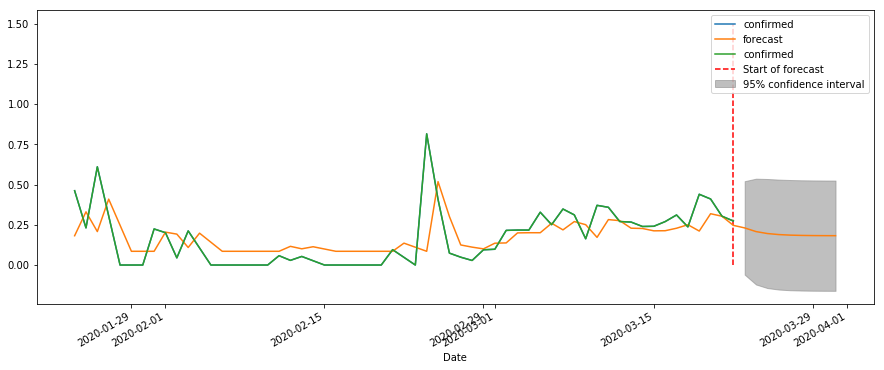

In [62]:
fig, ax = plt.subplots(figsize=(15, 6))
df_log_minus_mean.dropna().plot(ax=ax);
ax.vlines('2020, 3, 22', 0, 1.5, linestyle='--', color='r', label='Start of forecast');
# ax = results_mean.plot_predict(1,91, ax=ax) # other way to put in index number for start and end points
# # 10-day forecast
# ax = results_mean.plot_predict(start=results_mean.fittedvalues.index[0],end='2020, 4, 1', ax=ax)
# 9-day forecast
ax = results_mean.plot_predict(start=results_mean.fittedvalues.index[0],end='2020, 3, 31', ax=ax)
plt.savefig('ARIMA/Prediction_outOfSample_USA.pdf')
plt.show()

## Convert prediction/forecast back to original scale

https://machinelearningmastery.com/make-sample-forecasts-arima-python/

The predict() function can also forecast the next n out-of-sample time steps. Running the example produces the same results as calling the forecast() function, as you would expect.


In [52]:
# # 10-day forecast
# prediction_mean=results_mean.predict(start='2020, 1, 24',end='2020, 4, 1')
# 9-day forecast
prediction_mean=results_mean.predict(start='2020, 1, 24',end='2020, 3, 31')

predictions_ARIMA_diff = pd.Series(prediction_mean, copy = True)
# predictions_ARIMA_diff = pd.Series(results_mean.fittedvalues, copy = True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
Predictions_ARIMA_log = pd.Series(df_log['confirmed'].iloc[0], index = predictions_ARIMA_diff_cumsum.index)
Predictions_ARIMA_log = Predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value = 0)
Predictions_ARIMA_new = np.exp(Predictions_ARIMA_log)

df_pred =Predictions_ARIMA_new.to_frame().astype(int)
df_pred.rename(columns={0:'Predicted'}, inplace=True)

trace0 = go.Scatter(y = df['confirmed'],x = df.index,mode = 'markers+lines',name = 'Confirmed Cases')
trace1 = go.Scatter(y = df_pred['Predicted'],x = df_pred.index, mode = 'markers+lines',name = 'Predicted Cases')

data = [trace0, trace1]
layout = dict(
#     title = ' Future Forecast of Confirmed Cases in USA', 
    title = ' 9-day Forecast of Confirmed Cases in USA '+'<br>' + 'March 23, 2020 - March 31, 2020',
    xaxis=dict(
        title= dict(text = 'Date',font = dict(color = 'black')),
        tickangle = -45,
        tickfont=dict(size = 4),
        automargin=True)
)

fig = go.Figure(data, layout)
off.iplot(fig)
# 9 day forecast
fig.write_html('Plots/9-day Forecast_USA.html')    # save as html file
fig.write_image('Plots/9-day Forecast_USA.pdf')    # save as image file

# # 10 day forecast
# fig.write_html('Plots/Future Prediction_USA.html')    # save as html file
# fig.write_image('Plots/Future Prediction_USA.pdf')    # save as image file

In [53]:
# 9-day forecast values
df_pred[-9:]

,Predicted
2020-03-23,44493
2020-03-24,54778
2020-03-25,66628
2020-03-26,80521
2020-03-27,96979
2020-03-28,116589
2020-03-29,140029
2020-03-30,168096
2020-03-31,201734


##### Combine the original data into forecast table

In [23]:
# namelist = ['Province/State','Country/Region','Lat','Long',' Population ','region']## convert IndexDatetime to 'date'
df_pred.index=df_pred.index.date
## convert columns to row
forecastTable =df_pred.rename_axis(None).astype(int).T
## Append to the original table
confirmedTable=df_UnitedStates.drop(namelist, axis=1).reset_index(drop=True)
confirmedTable.rename(index={0:'confirmed'},inplace=True)
forecastTable.ix['confirmed', 0:(confirmedTable.shape[1]-2)]=confirmedTable.ix[0, 2:].values

# forecastTable.to_csv('Files/FutureforcastTable_USA.csv')

AttributeError: 'Index' object has no attribute 'date'

### Final Estimates of Parameters

In [25]:
results_mean.params

const              0.182107
ar.L1.confirmed    0.530883
dtype: float64

In [26]:
results_mean.pvalues

const              0.000034
ar.L1.confirmed    0.000015
dtype: float64

https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARMAResults.forecast.html

ARMAResults.forecast(steps=1, exog=None, alpha=0.05)[source]

https://machinelearningmastery.com/make-sample-forecasts-arima-python/
    

The predict() function can also forecast the next n out-of-sample time steps. Running the example produces the same results as calling the forecast() function, as you would expect.



In [46]:
results_mean.forecast(steps=10, exog=None, alpha=0.05)[0]

array([0.23080239, 0.20795851, 0.19583108, 0.18939283, 0.18597488,
       0.18416034, 0.18319704, 0.18268563, 0.18241414, 0.18227001])

In [49]:
prediction_mean[-10:]

2020-03-23    0.230802
2020-03-24    0.207959
2020-03-25    0.195831
2020-03-26    0.189393
2020-03-27    0.185975
2020-03-28    0.184160
2020-03-29    0.183197
2020-03-30    0.182686
2020-03-31    0.182414
2020-04-01    0.182270
Freq: D, dtype: float64

##### Retrieve the confidence Intervals from forecase

In [64]:
results_forecast, stderr, conf_int=results_mean.forecast(steps=10, exog=None, alpha=0.05)

In [20]:
conf_int

array([[-0.05983122,  0.521436  ],
       [-0.12109172,  0.53700874],
       [-0.1432611 ,  0.53492326],
       [-0.15247626,  0.53126193],
       [-0.15667279,  0.52862254],
       [-0.15870644,  0.52702712],
       [-0.15973147,  0.52612554],
       [-0.16026027,  0.52563153],
       [-0.16053667,  0.52536494],
       [-0.16068218,  0.52522219]])

In [44]:
stderr

array([0.14828518, 0.16788586, 0.17300939, 0.17442621, 0.17482345,
       0.17493524, 0.17496674, 0.17497561, 0.17497812, 0.17497882])

In [65]:
prediction_upper=prediction_mean.copy()
prediction_lower=prediction_mean.copy()
prediction_upper[-10:]=conf_int[:,1]
prediction_lower[-10:]=conf_int[:,0]

In [66]:
predictions_ARIMA_diff = pd.Series(prediction_upper, copy = True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
Predictions_ARIMA_log = pd.Series(df_log['confirmed'].iloc[0], index = predictions_ARIMA_diff_cumsum.index)
Predictions_ARIMA_log = Predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value = 0)
Predictions_ARIMA_new_upper = np.exp(Predictions_ARIMA_log)

df_pred_upper =Predictions_ARIMA_new_upper.to_frame()
df_pred_upper.rename(columns={0:'Predicted'}, inplace=True)

In [67]:
predictions_ARIMA_diff = pd.Series(prediction_lower, copy = True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
Predictions_ARIMA_log = pd.Series(df_log['confirmed'].iloc[0], index = predictions_ARIMA_diff_cumsum.index)
Predictions_ARIMA_log = Predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value = 0)
Predictions_ARIMA_new_lower = np.exp(Predictions_ARIMA_log)

df_pred_lower =Predictions_ARIMA_new_lower.to_frame()
df_pred_lower.rename(columns={0:'Predicted'}, inplace=True)

In [68]:
trace0 = go.Scatter(y = df['confirmed'],x = df.index,mode = 'markers+lines',name = 'Confirmed Cases')
trace1 = go.Scatter(y = df_pred['Predicted'],x = df_pred.index, mode = 'markers+lines',name = 'Predicted Cases')
trace2 = go.Scatter(y = df_pred_upper['Predicted'][-10:],x = df_pred_upper.index[-10:], mode = 'lines',line={'dash': 'dash'},name = 'Predicted Upper CI')
trace3 = go.Scatter(y = df_pred_lower['Predicted'][-10:],x = df_pred_lower.index[-10:], mode = 'lines',line={'dash': 'dash'},name = 'Predicted Lower CI')



data = [trace0, trace1, trace2, trace3]
layout = dict(
    title = ' Future Forecast of Confirmed Cases in USA'+'<br>', 
    xaxis=dict(
        title= dict(text = 'Date',font = dict(color = 'black')),
        tickangle = -45,
        tickfont=dict(size = 4),
        automargin=True)
)

fig = go.Figure(data, layout)
off.iplot(fig)
fig.write_html('Plots/CB_Future Prediction_USA.html')    # save as html file
fig.write_image('Plots/CB_Future Prediction_USA.pdf')    # save as image file